Import 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from numpy.random import randint, randn, shuffle
from time import time
from scipy.stats import norm
from sklearn.utils import resample

Define Franke function

In [3]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

Plotting variables

In [4]:
figwidth = 10
figheigth = 10
fontsize = 18
seed = 231243

Create design matrix for for two dimensions

In [5]:
def create_X(x, y, n):
    #n is the order of the polynomial
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

Define R2 score function

In [6]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Define Mean Squared Error (MSE) function

In [7]:
def MSE(y_data,y_model):
    return np.sum((y_data-y_model)**2)/np.size(y_model)

OLS regression

In [8]:
def ols(X_test, X_train, z_test, z_train):
    """
    Perform OLS regression
    return z_predict and z_tilde
    """
    beta_ols = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta_ols
    z_predict = X_test @ beta_ols
    
    return z_predict, z_tilde, beta_ols

Ridge regression

In [9]:
def ridge(X_test, X_train, z_test, z_train, _lambda):
    """
    Perform Ridge regression
    return z_predict and z_tilde and the resulting beta values
    """
    I = np.eye(X_train.shape[1])
    beta_ridge = np.linalg.pinv(X_train.T @ X_train + _lambda*I) @ X_train.T @ z_train #beta from Ridge-regression
    z_tilde = X_train @ beta_ridge
    z_predict = X_test @ beta_ridge
    
    return z_predict, z_tilde, beta_ridge

Lasso regression

In [10]:
def lasso(X_test, X_train, z_test, z_train, _lambda, tol):
    """
    Perform Lasso-regression using SciKit learn
    return z_predict, z_tilde and the resulting beta values
    """
    np.random.seed(seed)
    clf_lasso = skl.Lasso(alpha=_lambda, fit_intercept=False, normalize=True, tol=tol, random_state=11).fit(X_train, z_train)
    beta_lasso = clf_lasso.coef_
            
    z_tilde = X_train @ beta_lasso
    z_predict = X_test @ beta_lasso
    
    return z_predict, z_tilde, beta_lasso

Bootstrap function

In [11]:
def resample_bootstrap(method, n_bootstraps, X_train, X_test, z_train, z_test, _lambda=1, tol = 0.04):
    """
    Perform bootstrap resampling for n_bootstraps
    Return the mean bootstrap MSE for the given complexity and the predicted data
    Need to choose method=ols, method=ridge or method=lasso
    tol only for lasso regression
    """
    
    MSE_test_values = np.zeros(n_bootstraps)
    z_predict = np.empty((X_test.shape[0], n_bootstraps))
    I = np.eye(X_train.shape[1] + X_test.shape[1])
    
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        if method==ols:
            z_predict[:, j], z_tilde_ols, beta_boot = ols(X_test, X_train_resample, z_test, z_train_resample)
        if method==ridge:
            z_predict[:, j], z_tilde, beta_boot = ridge(X_test, X_train_resample, z_test, z_train_resample, _lambda)
        if method==lasso:
            z_predict[:, j], z_tilde, beta_boot = lasso(X_test, X_train_resample, z_test, z_train_resample, _lambda, tol=tol)
            
        MSE_test_values[j] = MSE(z_test, z_predict[:, j])
    
    MSE_test = np.mean(MSE_test_values)
    
    return MSE_test, z_predict, beta_boot


K-fold cross validation function

In [12]:
def kfold_crossValidation(method, X, z, k_folds, _lambda=1, tol=0.04):
    
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(z) #make sure X and z are shuffled together
    z_split = np.array_split(z, k_folds)
    X_split = np.array_split(X, k_folds)
    MSE_test_values = np.zeros(k_folds)

    for k in range(k_folds):
        z_test = z_split[k]
        z_train = np.concatenate(np.delete(z_split, k, 0))

        X_test = X_split[k] #picks out the kth matrix from X
        X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
            
        X_train, X_test = scaleData(X_train, X_test)
        
        if method==ols:
            z_predict, z_tilde, beta_kfold = ols(X_test, X_train, z_test, z_train)
        if method==ridge:
            z_predict, z_tilde, beta_kfold = ridge(X_test, X_train, z_test, z_train, _lambda)
        if method==lasso:
            z_predict, z_tilde, beta_kfold = lasso(X_test, X_train, z_test, z_train, _lambda, tol=tol)
            
        MSE_test_values[k] = MSE(z_test,z_predict)
            
    MSE_test = np.mean(MSE_test_values)
    return MSE_test, z_predict, beta_kfold

Generating Data

In [13]:
def generateData(n, polydegree, noise_factor):
    """
    n = size opf x and y
    degree = polynomial d
    noise_factor = self explanatory
    """
    np.random.seed(seed+seed)
    noise = noise_factor*np.random.randn(n)
    x = np.random.uniform(0,1,n)
    y = np.random.uniform(0,1,n)
    z = FrankeFunction(x,y) + noise
    X = create_X(x, y, polydegree)
    return z, X

Scale data

In [14]:
def scaleData(X_train, X_test):
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    X_train_scaled = (X_train - X_mean)/X_std
    X_test_scaled = (X_test - X_mean)/X_std
    return X_train_scaled, X_test_scaled

Perform the Ordinary Least Square (OLS) method and print the MSE and R2 results

In [15]:
z, X = generateData(n=100, polydegree=9, noise_factor=0.1)
np.random.seed(seed)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

X_train, X_test = scaleData(X_train, X_test)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

z_tilde = X_train @ beta
z_predict = X_test @ beta

print("Training R2")
print(R2(z_train,z_tilde))
print(' ')
print("Training MSE")
print(MSE(z_train,z_tilde))
print(' ')
print("Test R2")
print(R2(z_test,z_predict))
print(' ')
print("Test MSE")
print(MSE(z_test,z_predict))

Training R2
0.9668877021275485
 
Training MSE
0.002824540199845698
 
Test R2
-1.7256685612757288
 
Test MSE
0.23752227241782214


We see that the MSE from the test data, is higher than the training data. This is for higher complexity. For lower complexity, we see that they are more equal.

Study the bias-variance trade-off by plotting the MSE for increasing model complexity (i.e. the number of polynomials)

Implement bootstrap resampling

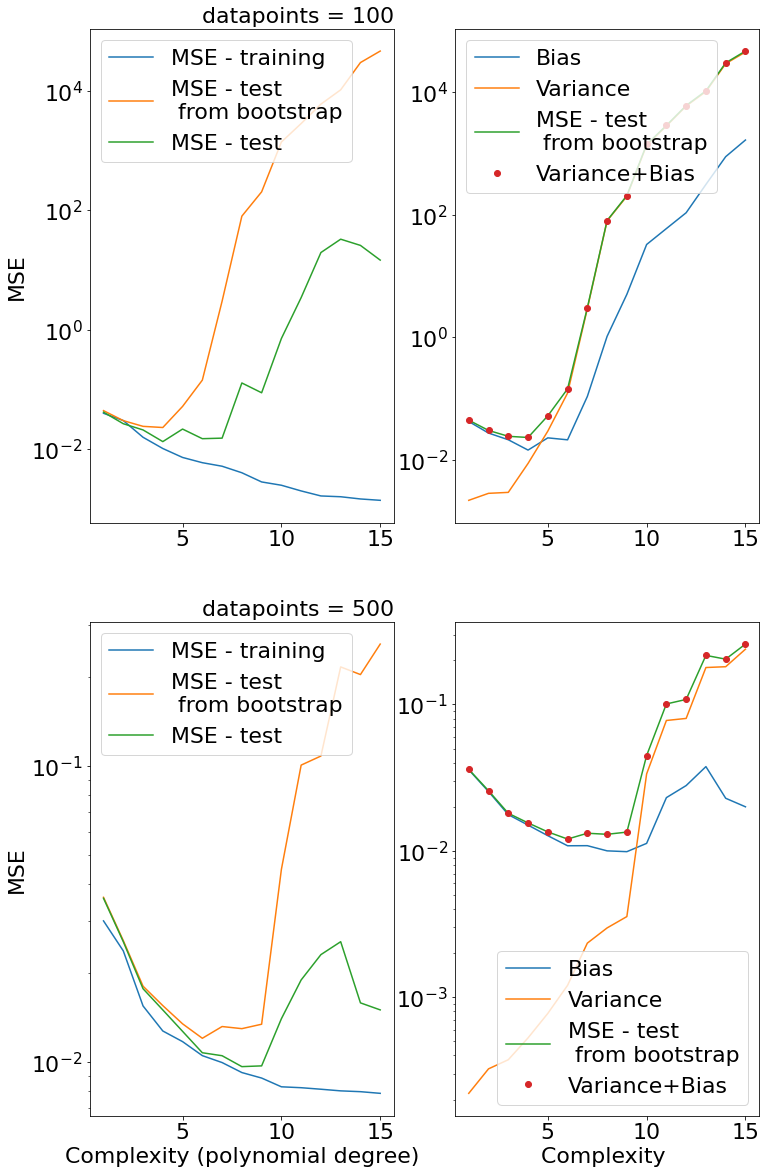

In [16]:
max_degree = 15
degree = np.linspace(1, max_degree, max_degree)
datapoints = [100, 500, 1000]
MSE_test = np.zeros((len(datapoints), len(degree)))
MSE_train = np.zeros((len(datapoints), len(degree)))
MSE_test_bootstrap = np.zeros((len(datapoints), len(degree)))


bias = np.zeros((len(datapoints), len(degree)))
variance = np.zeros((len(datapoints), len(degree)))
for j in range(len(datapoints)):
    points = datapoints[j]
    for i in range(max_degree):
        z, X = generateData(points, polydegree = int(degree[i]), noise_factor = 0.1)

        np.random.seed(seed)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

        X_train, X_test = scaleData(X_train, X_test)
        z_predict, z_tilde, beta_OLS = ols(X_test, X_train, z_test, z_train)

        MSE_train[j][i] = MSE(z_train,z_tilde)
        MSE_test[j][i] = MSE(z_test,z_predict)

        #Perform OLS with bootstrap resampling
        n_bootstraps = 100
        MSE_test_bootstrap_val, z_predicted_bootstrap, beta_bootstrap = resample_bootstrap(ols, n_bootstraps, X_train, X_test, z_train, z_test)
        MSE_test_bootstrap[j][i] = MSE_test_bootstrap_val

        bias[j][i] = np.mean( (z_test - np.mean(z_predicted_bootstrap, axis=1))**2 )
        variance[j][i] = np.mean(np.var(z_predicted_bootstrap, axis=1))

        
        
  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(20)
fig.set_figwidth(12)

textsize=22

ax1.tick_params(axis='both', which='both', labelsize=textsize)
ax1.set_ylabel('MSE', fontsize=textsize)
ax1.plot(degree, MSE_train[0,:], label='MSE - training') 
ax1.plot(degree, MSE_test_bootstrap[0,:], label='MSE - test \n from bootstrap') 
ax1.plot(degree, MSE_test[0,:], label='MSE - test')
ax1.set_yscale('log')
ax1.legend(fontsize=textsize, loc='upper left')
ax1.set_title('datapoints = 100', fontsize=textsize, loc='right')

ax2.tick_params(axis='both', which='both', labelsize=textsize)
ax2.plot(degree, bias[0,:], label='Bias') 
ax2.plot(degree, variance[0,:], label='Variance')
ax2.plot(degree, MSE_test_bootstrap[0,:], label='MSE - test \n from bootstrap')
ax2.plot(degree, variance[0,:]+bias[0,:], 'o', label='Variance+Bias')
ax2.set_yscale('log')
ax2.legend(fontsize=textsize, loc='upper left')

ax3.tick_params(axis='both', which='both', labelsize=textsize)
ax3.set_ylabel('MSE', fontsize=textsize)
ax3.plot(degree, MSE_train[1,:], label='MSE - training') 
ax3.plot(degree, MSE_test_bootstrap[1,:], label='MSE - test \n from bootstrap') 
ax3.plot(degree, MSE_test[1,:], label='MSE - test')
ax3.set_yscale('log')
ax3.legend(fontsize=textsize, loc='upper left')
ax3.set_title('datapoints = 500', fontsize=textsize, loc='right')
ax3.set_xlabel('Complexity (polynomial degree)', fontsize=textsize)

ax4.tick_params(axis='both', which='both', labelsize=textsize)
ax4.plot(degree, bias[1,:], label='Bias') 
ax4.plot(degree, variance[1,:], label='Variance')
ax4.plot(degree, MSE_test_bootstrap[1,:], label='MSE - test \n from bootstrap')
ax4.plot(degree, variance[1,:]+bias[1,:], 'o', label='Variance+Bias')
ax4.set_yscale('log')
ax4.legend(fontsize=textsize, loc='lower right')
ax4.set_xlabel('Complexity ', fontsize=textsize)

plt.savefig('figures/MSE_bias_variance_franke.pdf', dpi=300)
plt.show()

Implement k-fold cross validation

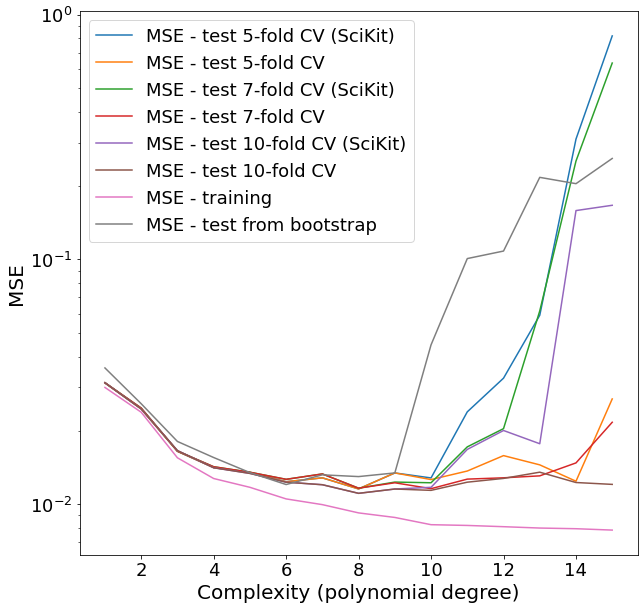

In [17]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)

plt.figure(figsize=(figwidth, figheigth))

for k_folds in folds:
    
    MSE_test_kfold = np.zeros(len(degree))
    MSE_test_kfold_scikit = np.zeros(len(degree))
    
    for i in range(max_degree):

        z, X = generateData(n = datapoints[1], polydegree = int(degree[i]), noise_factor = 0.1)

        MSE_test_kfold[i] = kfold_crossValidation(ols, X, z, k_folds)[0]

        #k-fold cross validation using SciKit    
        kfold_scikit = KFold(n_splits = k_folds)
        MSE_test_kfold_values_scikit = np.zeros(k_folds)

        k=0
        for train_inds, test_inds in kfold_scikit.split(X):

            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]

            X_train, X_test = scaleData(X_train, X_test)

            model = LinearRegression(fit_intercept=True).fit(X_train, z_train)
            z_predict = model.predict(X_test)
            z_tilde = model.predict(X_train)
            MSE_test_kfold_values_scikit[k] = MSE(z_test,z_predict)
            k+=1

            MSE_test_kfold_scikit[i] = np.mean(MSE_test_kfold_values_scikit)

    plt.plot(degree, MSE_test_kfold_scikit, label='MSE - test %.i-fold CV (SciKit)'%k_folds)   
    plt.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)


plt.ylabel('MSE', fontsize=20)
plt.xlabel('Complexity (polynomial degree)', fontsize=20)
plt.plot(degree, MSE_train[1,:], label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap[1,:], label='MSE - test from bootstrap')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.savefig('figures/mse_kfold_bootstrap_franke_%.0i_points.pdf' %datapoints[1], dpi=300)
plt.show()

Implement Ridge Regression and Lasso on Franke data

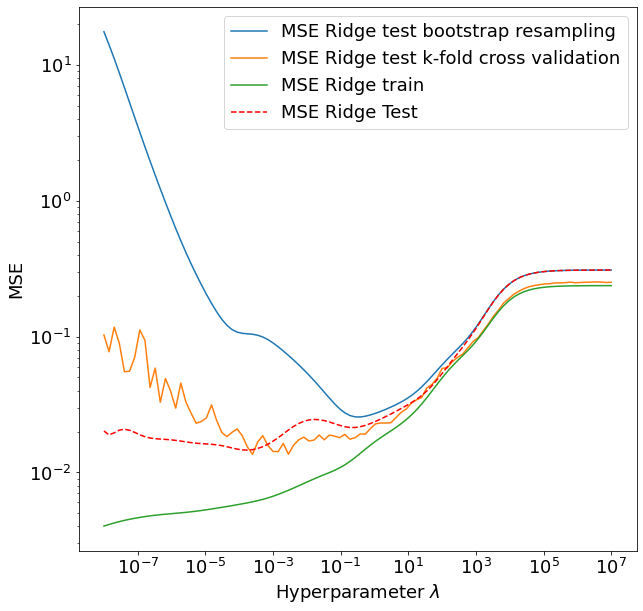

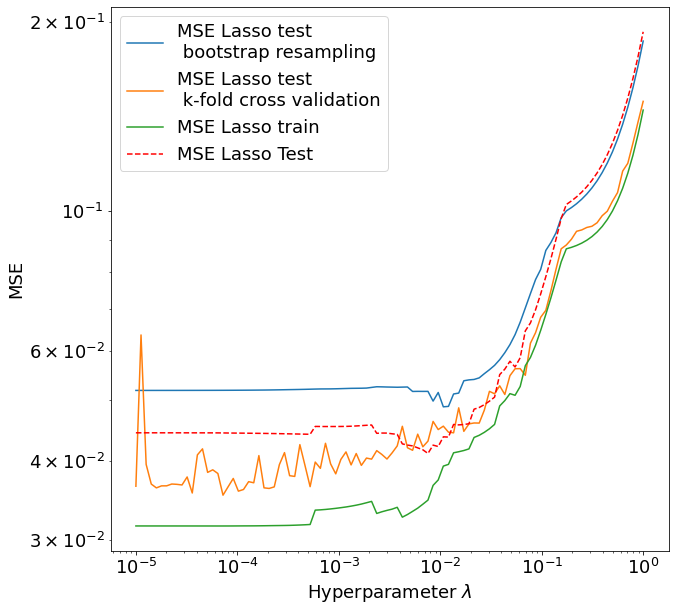

In [18]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

p = 10 #polynomial degree
nlambdas = 100
lambdas_ridge = np.logspace(-8, 7, nlambdas)
lambdas_lasso = np.logspace(-5, 0, nlambdas)

MSE_test_ridge = np.zeros(nlambdas)
MSE_train_ridge = np.zeros(nlambdas)
MSE_test_ridge_bootstrap = np.zeros(nlambdas)
MSE_test_ridge_kfold = np.zeros(nlambdas)

MSE_test_lasso = np.zeros(nlambdas)
MSE_train_lasso = np.zeros(nlambdas)
MSE_test_lasso_bootstrap = np.zeros(nlambdas)
MSE_test_lasso_kfold = np.zeros(nlambdas)


        
z, X = generateData(n = 100, polydegree = p, noise_factor = 0.1)
#split data
np.random.seed(seed)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

X_train, X_test = scaleData(X_train, X_test)

for i in range(nlambdas):
    _lambda = lambdas_ridge[i]

    #perform Ridge regression with bootstrap resampling and k-fold cross validation
    z_predict, z_tilde, beta_ridge = ridge(X_test, X_train, z_test, z_train, _lambda)

    MSE_train_ridge[i] = MSE(z_train, z_tilde)
    MSE_test_ridge[i] = MSE(z_test, z_predict)

    MSE_test_ridge_bootstrap[i] = resample_bootstrap(ridge, 100, X_train, X_test, z_train, z_test, _lambda = _lambda)[0]

    MSE_test_ridge_kfold[i] = kfold_crossValidation(ridge, X, z, k_folds=7, _lambda=_lambda)[0]

    _lambda = lambdas_lasso[i]
    #perform Lasso regression with bootstrap resampling and k-fold cross validation

    z_predict, z_tilde, beta_lasso = lasso(X_test, X_train, z_test, z_train, _lambda, tol=0.08)

    MSE_train_lasso[i] = MSE(z_train, z_tilde)
    MSE_test_lasso[i] = MSE(z_test, z_predict)

    MSE_test_lasso_bootstrap[i] = resample_bootstrap(lasso, 100, X_train, X_test, z_train, z_test, _lambda = _lambda, tol = 0.08)[0]

    MSE_test_lasso_kfold[i] = kfold_crossValidation(lasso, X, z, k_folds=7, _lambda=_lambda, tol = 0.08)[0]
    

    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=18)
plt.plot(lambdas_ridge, MSE_test_ridge_bootstrap, label = 'MSE Ridge test bootstrap resampling')
plt.plot(lambdas_ridge, MSE_test_ridge_kfold, label = 'MSE Ridge test k-fold cross validation')
plt.plot(lambdas_ridge, MSE_train_ridge, label = 'MSE Ridge train')
plt.plot(lambdas_ridge, MSE_test_ridge, 'r--', label = 'MSE Ridge Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hyperparameter $\lambda$', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='upper right')
plt.savefig('figures/MSE_ridge_franke.pdf', dpi=300)
plt.show()


plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=18)
plt.plot(lambdas_lasso, MSE_test_lasso_bootstrap, label = 'MSE Lasso test \n bootstrap resampling')
plt.plot(lambdas_lasso, MSE_test_lasso_kfold, label = 'MSE Lasso test \n k-fold cross validation')
plt.plot(lambdas_lasso, MSE_train_lasso, label = 'MSE Lasso train')
plt.plot(lambdas_lasso, MSE_test_lasso, 'r--', label = 'MSE Lasso Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hyperparameter $\lambda$', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='upper left')
plt.savefig('figures/MSE_lasso_franke.pdf', dpi=300)
plt.show()

Prepare real data for analysis

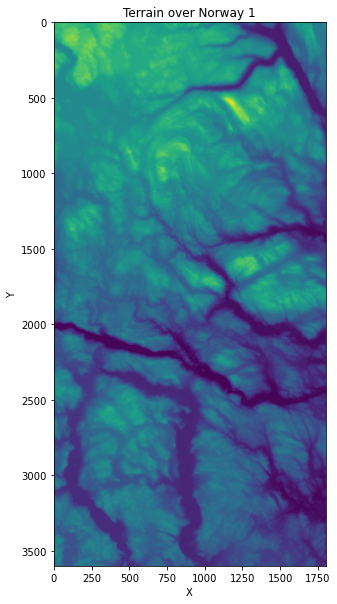

In [19]:
# Load the terrain
terrain_file = imread('Datafiles/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure(figsize=(figwidth, figheigth))
plt.title('Terrain over Norway 1')
plt.imshow(terrain_file)#, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


terrain_file = imread('Datafiles/SRTM_data_Norway_1.tif')
x = np.linspace(0,1,terrain_file.shape[1])
y = np.linspace(0,1,terrain_file.shape[0])
x_grid, y_grid = np.meshgrid(x,y)
z_data = terrain_file

##Cutting
x_values = x_grid[1::300, 1::150]
y_values = y_grid[1::300, 1::150]
z_values = z_data[1::300, 1::150]

z = z_values.ravel()

Real data k-fold analysis

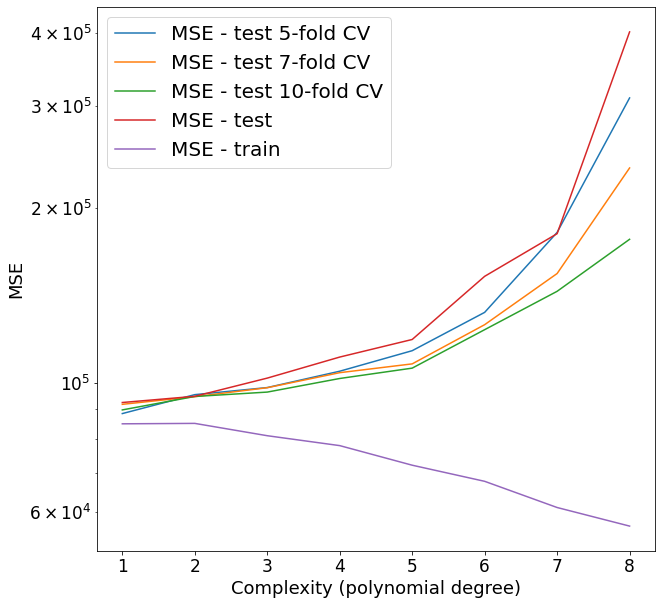

In [20]:
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #not exactly sure if i need this...

max_degree = 8
folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)

MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)

plt.figure(figsize=(figwidth, figheigth))

reps = 10
for k_folds in folds:
    MSE_test_kfold = np.zeros(len(degree))
    MSE_test_kfold_scikit = np.zeros(len(degree))
    for j in range(reps):

        for i in range(max_degree):
            X = create_X(x_values,y_values,int(degree[i]))
            MSE_test_kfold[i] += kfold_crossValidation(ols, X, z, k_folds)[0]
            
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True)
            X_train, X_test = scaleData(X_train, X_test)
            z_predict, z_tilde, beta_ols = ols(X_test, X_train, z_test, z_train)
            MSE_train[i] += MSE(z_train,z_tilde)
            MSE_test[i] += MSE(z_test,z_predict)
            
    MSE_test_kfold /= reps
    plt.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)
MSE_train /= len(folds)*reps
MSE_test /= len(folds)*reps 



plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
plt.plot(degree, MSE_test, label='MSE - test')
plt.plot(degree, MSE_train, label='MSE - train')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=17)
plt.legend(fontsize=20, loc='upper left')
plt.savefig('figures/mse_kfold_terrain.pdf', dpi=300)
plt.show()

Real data Ridge and Lasso analysis

In [21]:
poly = [5, 10, 15, 20]
no_of_folds = 7
nlambdas = 100
reps = 10
lambdas_ridge = np.logspace(-15, 8, nlambdas)
lambdas_lasso = np.logspace(-2, 3, nlambdas)


MSE_test_ridge = np.zeros((4, nlambdas))
MSE_train_ridge = np.zeros((4, nlambdas))
MSE_test_ridge_kfold = np.zeros((4, nlambdas))

MSE_test_lasso = np.zeros((4, nlambdas))
MSE_train_lasso = np.zeros((4, nlambdas))
MSE_test_lasso_kfold = np.zeros((4, nlambdas))



for k in range(len(poly)):
    print('Running for polydegree = %.0i'%poly[k])
    polydegree = poly[k]
    X = create_X(x_values, y_values, polydegree)
    for j in range(reps):
        #split data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True)
        X_train, X_test = scaleData(X_train, X_test)
        for i in range(nlambdas):
            _lambda = lambdas_ridge[i]

            #perform Ridge regression with k-fold cross validation
            z_predict, z_tilde, beta_ridge = ridge(X_test, X_train, z_test, z_train, _lambda)

            MSE_train_ridge[k][i] += MSE(z_train, z_tilde)
            MSE_test_ridge[k][i] += MSE(z_test, z_predict)

            MSE_test_ridge_kfold[k][i] += kfold_crossValidation(ridge, X, z, k_folds=no_of_folds, _lambda=_lambda)[0]

            _lambda = lambdas_lasso[i]
            #perform Lasso regression with k-fold cross validation

            z_predict, z_tilde, beta_lasso = lasso(X_test, X_train, z_test, z_train, _lambda, tol=.085)

            MSE_train_lasso[k][i] += MSE(z_train, z_tilde)
            MSE_test_lasso[k][i] += MSE(z_test, z_predict)

            MSE_test_lasso_kfold[k][i] += kfold_crossValidation(lasso, X, z, k_folds=no_of_folds, _lambda=_lambda, tol=.085)[0]

    MSE_test_ridge[k] /= reps
    MSE_train_ridge[k] /= reps
    MSE_test_ridge_kfold[k] /= reps

    MSE_test_lasso[k] /= reps
    MSE_train_lasso[k] /= reps
    MSE_test_lasso_kfold[k] /= reps


Running for polydegree = 5
Running for polydegree = 10
Running for polydegree = 15
Running for polydegree = 20


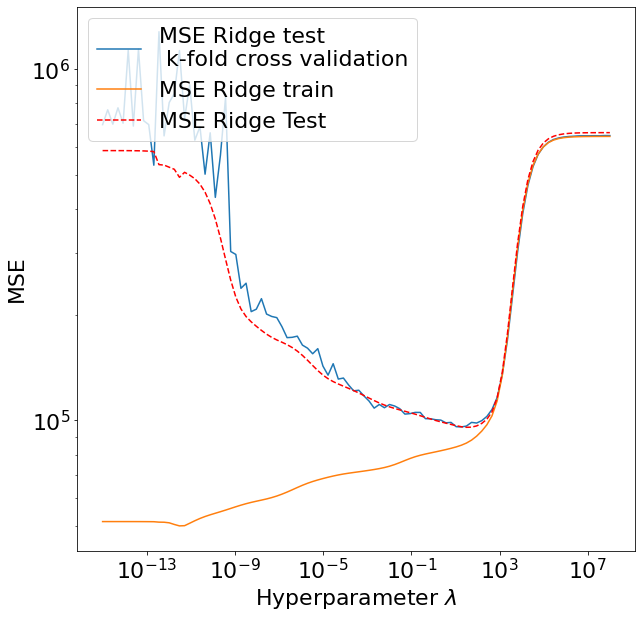

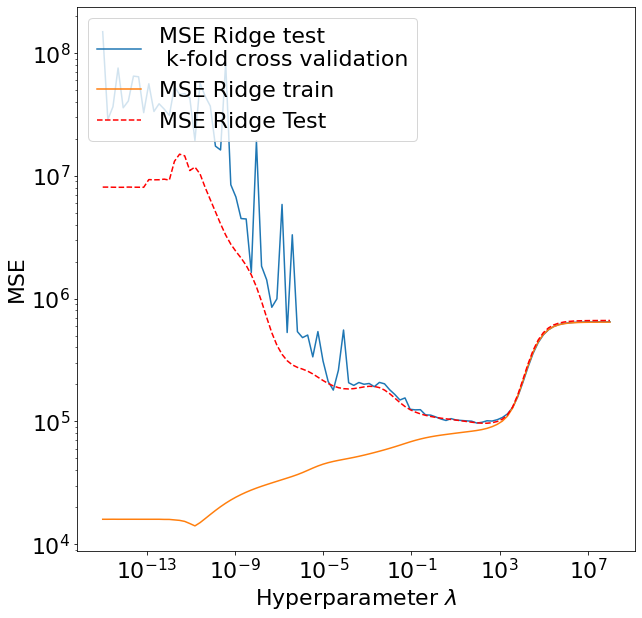

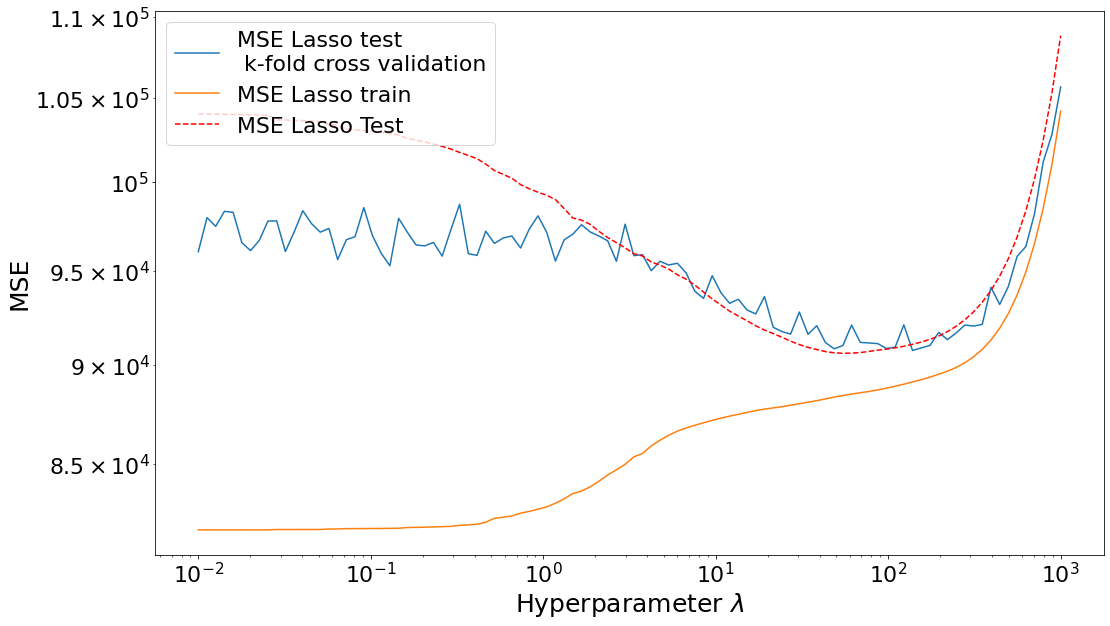

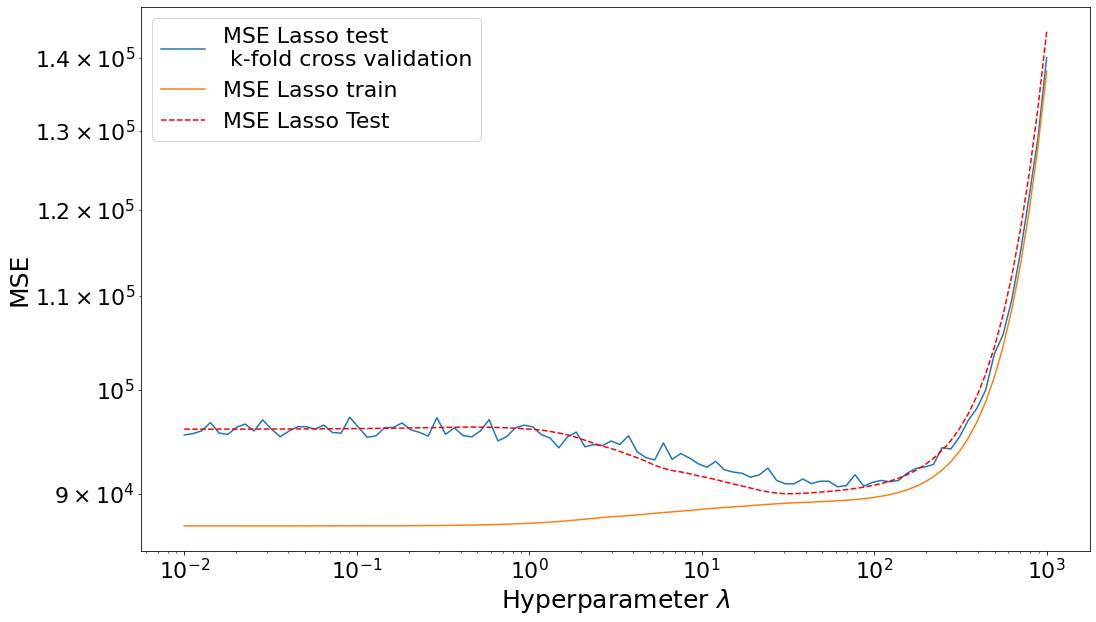

In [32]:
import matplotlib.ticker
textsize=22

fig, ax1 = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(lambdas_ridge, MSE_test_ridge_kfold[1,:], label = 'MSE Ridge test \n k-fold cross validation')
ax1.plot(lambdas_ridge, MSE_train_ridge[1,:], label = 'MSE Ridge train')
ax1.plot(lambdas_ridge, MSE_test_ridge[1,:], 'r--', label = 'MSE Ridge Test')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('MSE', fontsize=textsize)
ax1.set_xlabel('Hyperparameter $\lambda$', fontsize=textsize)
ax1.legend(fontsize=textsize, loc='upper left')
ax1.tick_params(axis='both', which='both', labelsize=textsize)

plt.savefig('figures/MSE_ridge_terrain_poly10.pdf', dpi=300)
plt.show()


fig, ax1 = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(lambdas_ridge, MSE_test_ridge_kfold[3,:], label = 'MSE Ridge test \n k-fold cross validation')
ax1.plot(lambdas_ridge, MSE_train_ridge[3,:], label = 'MSE Ridge train')
ax1.plot(lambdas_ridge, MSE_test_ridge[3,:], 'r--', label = 'MSE Ridge Test')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('MSE', fontsize=textsize)
ax1.set_xlabel('Hyperparameter $\lambda$', fontsize=textsize)
ax1.legend(fontsize=textsize, loc='upper left')
ax1.tick_params(axis='both', which='both', labelsize=textsize)

plt.savefig('figures/MSE_ridge_terrain_poly20.pdf', dpi=300)
plt.show()




fig, ax1 = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(17)

ax1.plot(lambdas_lasso, MSE_test_lasso_kfold[3,:], label = 'MSE Lasso test \n k-fold cross validation')
ax1.plot(lambdas_lasso, MSE_train_lasso[3,:], label = 'MSE Lasso train')
ax1.plot(lambdas_lasso, MSE_test_lasso[3,:], 'r--', label = 'MSE Lasso Test')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('MSE', fontsize=25)
ax1.set_xlabel('Hyperparameter $\lambda$', fontsize=25)
ax1.legend(fontsize=textsize, loc='upper left')
ax1.tick_params(axis='both', which='both', labelsize=textsize)

plt.savefig('figures/MSE_lasso_terrain_poly20.pdf', dpi=300)
plt.show()



fig, ax1 = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(17)

ax1.plot(lambdas_lasso, MSE_test_lasso_kfold[1,:], label = 'MSE Lasso test \n k-fold cross validation')
ax1.plot(lambdas_lasso, MSE_train_lasso[1,:], label = 'MSE Lasso train')
ax1.plot(lambdas_lasso, MSE_test_lasso[1,:], 'r--', label = 'MSE Lasso Test')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('MSE', fontsize=25)
ax1.set_xlabel('Hyperparameter $\lambda$', fontsize=25)
ax1.legend(fontsize=textsize, loc='upper left')
ax1.set_yticks([9e4, 1e5])
ax1.tick_params(axis='both', which='both', labelsize=textsize)

plt.savefig('figures/MSE_lasso_terrain_poly10.pdf', dpi=300)
plt.show()



In [35]:
max_degree = 20

degree = np.linspace(1, max_degree, max_degree)

MSE_test_ridge_kfold = np.zeros((nlambdas, len(degree)))
MSE_test_lasso_kfold = np.zeros((nlambdas, len(degree)))
MSE_test_ols_kfold = np.zeros(len(degree))


for i in range(max_degree):
    print('Running for polydegree %.0i' %int(degree[i]))
    X = create_X(x_values,y_values,int(degree[i]))
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True)

    X_train, X_test = scaleData(X_train, X_test)
    for rep in range(reps):
        MSE_test_ols_kfold[i] += kfold_crossValidation(ols, X, z, k_folds)[0]
        for j in range(nlambdas):

            #perform Ridge regression with k-fold cross validation
            _lambda = lambdas_ridge[j]
            z_predict, z_tilde, beta_ridge = ridge(X_test, X_train, z_test, z_train, _lambda)
            MSE_test_ridge_kfold[j][i] += kfold_crossValidation(ridge, X, z, k_folds=no_of_folds, _lambda=_lambda)[0]
            
            #perform Lasso regression with k-fold cross validation
            _lambda = lambdas_lasso[j]
            z_predict, z_tilde, beta_lasso = lasso(X_test, X_train, z_test, z_train, _lambda, tol=.085)
            MSE_test_lasso_kfold[j][i] += kfold_crossValidation(lasso, X, z, k_folds=no_of_folds, _lambda=_lambda, tol=.085)[0]

MSE_test_ridge_kfold /= reps
MSE_test_ols_kfold /= reps
MSE_test_lasso_kfold /= reps

#export to CSV
pd.DataFrame(MSE_test_ridge_kfold).to_csv(r'terrain_data/MSE_test_ridge_kfold_c%.0i_k%.0i_l%.0i_r%.0i.csv'%(max_degree, no_of_folds, nlambdas, reps), index = False, header=True)
pd.DataFrame(MSE_test_lasso_kfold).to_csv(r'terrain_data/MSE_test_lasso_kfold_c%.0i_k%.0i_l%.0i_r%.0i.csv'%(max_degree, no_of_folds, nlambdas, reps), index = False, header=True)
pd.DataFrame(MSE_test_ols_kfold).to_csv(r'terrain_data/MSE_test_ols_kfold_c%.0i_k%.0i_r%.0i.csv'%(max_degree, no_of_folds, reps), index = False, header=True)



Running for polydegree 1


KeyboardInterrupt: 

In [36]:
#import CSV-files
#these values gives a good illustration for the report
    
MSE_test_ridge_kfold = pd.read_csv (r'terrain_data/MSE_test_ridge_kfold_c20_k7_l100_r10.csv')
MSE_test_lasso_kfold = pd.read_csv (r'terrain_data/MSE_test_lasso_kfold_c20_k7_l100_r10.csv')
MSE_test_ols_kfold = pd.read_csv (r'terrain_data/MSE_test_ols_kfold_c20_k7_r25.csv')

/Users/tellefs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


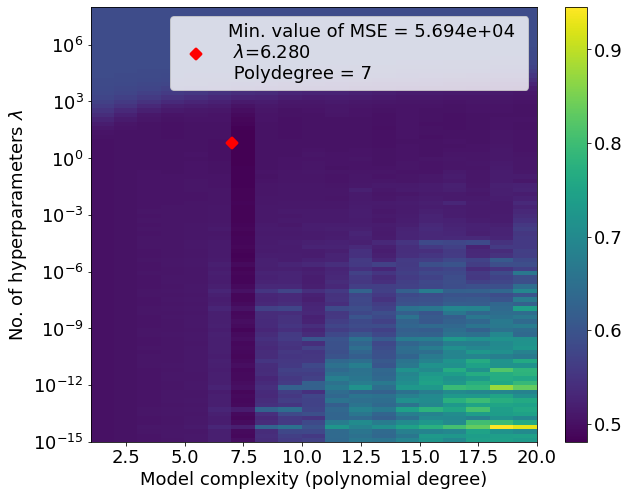

/Users/tellefs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


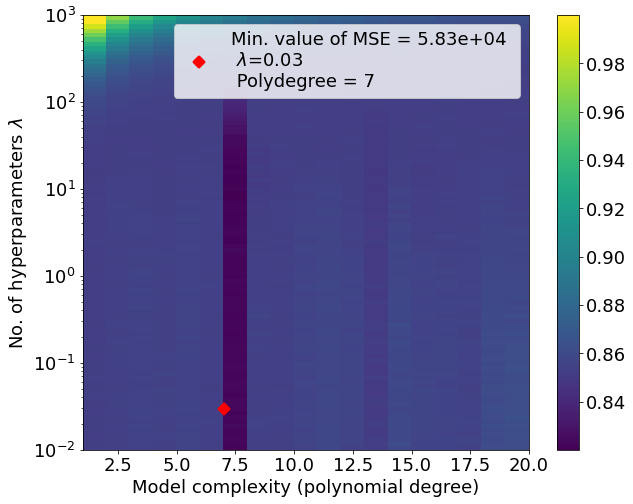

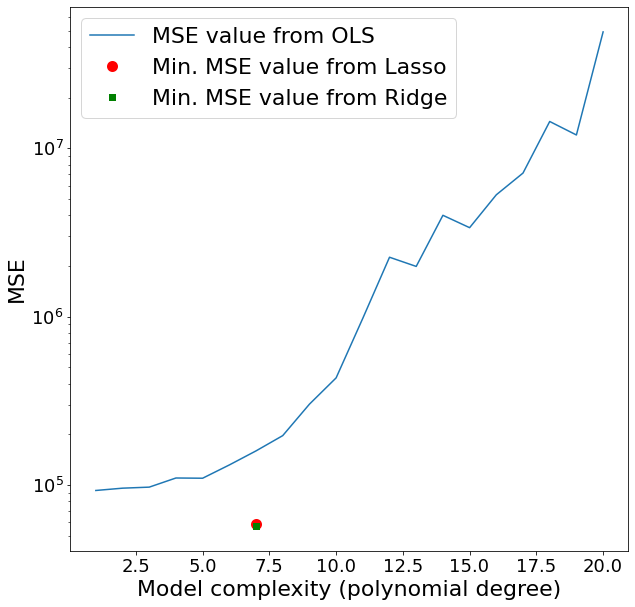

In [67]:
#make colormesh plots of the best fitted value

fig, ax = plt.subplots(figsize=(10, 8))

min_ridge_degree = degree[int(MSE_test_ridge_kfold.stack().idxmin()[1])]
min_ridge_lambda = lambdas_ridge[int(MSE_test_ridge_kfold.stack().idxmin()[0])]
min_ridge = MSE_test_ridge_kfold.min().min()


im = ax.pcolor(degree, lambdas_ridge, 
               np.log10(MSE_test_ridge_kfold)/np.log10(MSE_test_ridge_kfold).max().max(), shading='flat')
plt.plot(min_ridge_degree , min_ridge_lambda, 'rx', label='Min. value of MSE = %.3e \n $\lambda$=%.3f \n Polydegree = %.0i' %(min_ridge, min_ridge_lambda, min_ridge_degree ), mew=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_ylabel('No. of hyperparameters $\lambda$', fontsize=18)
ax.set_xlabel('Model complexity (polynomial degree)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.savefig("figures/optimal_mse_ridge.pdf", dpi=300)
plt.show()




fig, ax = plt.subplots(figsize=(10, 8))

min_lasso_degree = degree[int(MSE_test_lasso_kfold.stack().idxmin()[1])]
min_lasso_lambda = lambdas_ridge[int(MSE_test_lasso_kfold.stack().idxmin()[0])]
min_lasso = MSE_test_lasso_kfold.min().min()


im = ax.pcolor(degree, lambdas_lasso, np.log10(MSE_test_lasso_kfold)/np.log10(MSE_test_lasso_kfold).max().max(), shading='flat')
plt.plot(min_lasso_degree , min_lasso_lambda, 'rx', label='Min. value of MSE = %.2e \n $\lambda$=%.2f \n Polydegree = %.0i' %(min_lasso, min_lasso_lambda, min_lasso_degree ), mew=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_ylabel('No. of hyperparameters $\lambda$', fontsize=18)
ax.set_xlabel('Model complexity (polynomial degree)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.savefig("figures/optimal_mse_lasso.pdf", dpi=300)
plt.show()



fig, ax = plt.subplots(figsize=(10,10))

ax.plot(degree, MSE_test_ols_kfold, label='MSE value from OLS')
ax.plot(7, min_lasso, 'ro', label='Min. MSE value from Lasso', mew=5)
ax.plot(7, min_ridge, 'g+', label='Min. MSE value from Ridge', mew=7)
ax.set_yscale('log')
ax.set_xlabel("Model complexity (polynomial degree)", fontsize=22)
ax.set_ylabel('MSE', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=22)
plt.savefig('figures/optimal_mse_ols.pdf', dpi=300)
plt.show()


Make 3D-plot of the best MSE, based on complexity and lambda

In [ ]:
def make_3D_plot(beta, degree, z_data):
    scaling_factor=step=5
    px = np.arange(0,z_data.shape[1],step,dtype=int)
    py = np.arange(0,z_data.shape[0],step,dtype=int)
    terrain_fit_OLS = np.zeros((len(py),len(px)))
    terrain_scaled = np.zeros((len(py),len(px)))
    lenpx = len(px)
    lenpy = len(py)
    px, py = np.meshgrid(px,py)
    px = px.ravel()
    py = py.ravel()
    X = create_X(px,py,degree)
    z = X @ beta
    for i in range(lenpx):
        for j in range(lenpy):
            terrain_fit_OLS[j,i]=z[i*lenpy+j]
            
    fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(9, 3))
    mapstyle="rainbow"
    #ax2.set_title("Original")
    #ax0.set_title("OLS degree %d"%(ideal_degree_OLS))
    im0=ax0.imshow(terrain_fit_OLS, cmap=mapstyle)#,vmin = 0, vmax = 2000)
    im1=ax1.imshow(z_data, cmap=mapstyle)#, vmin = 0, vmax = 2000)
    #cbar=plt.colorbar(im,ax=ax)
    #cbar.set_label("Height [m]")
    fig.colorbar(im0,ax=ax0)
    fig.colorbar(im1,ax=ax1)
    plt.show()